Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

Read raw csv file into DataFrame - updated headers in Excel for ease of use.

In [2]:
df = pd.read_csv('Comma Data Updated Headers.csv')

In [3]:
df.head()

,RespondentID,Sentence,OxfordCommaHeard,OxfordCommaCare,Unnamed: 4,DataPlural,DataPluralCare,GrammarImportance,Gender,Age,Income,Education,Location
0,3292953864,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Not much,Somewhat important,Male,30-44,"$50,000 - $99,999",Bachelor degree,South Atlantic
1,3292950324,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,Somewhat unimportant,Male,30-44,"$50,000 - $99,999",Graduate degree,Mountain
2,3292942669,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",Yes,Not at all,Very important,Male,30-44,NaN,NaN,East North Central
3,3292932796,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Some,Somewhat important,Male,18-29,NaN,Less than high school degree,Middle Atlantic
4,3292932522,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,NaN,NaN,NaN,NaN,NaN,NaN


Impute Income based on Gender & Age, create new DataFrame

In [4]:
df = df.dropna(subset = ['Gender', 'Age'])
imputed = df.groupby(["Gender", "Age"]).transform(lambda x: x.fillna(x.value_counts().index[0]))
del df['Income']
df2 = pd.concat([df, imputed['Income']], axis=1, join='inner')
df2.head()

,RespondentID,Sentence,OxfordCommaHeard,OxfordCommaCare,Unnamed: 4,DataPlural,DataPluralCare,GrammarImportance,Gender,Age,Education,Location,Income
0,3292953864,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Not much,Somewhat important,Male,30-44,Bachelor degree,South Atlantic,"$50,000 - $99,999"
1,3292950324,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,Somewhat unimportant,Male,30-44,Graduate degree,Mountain,"$50,000 - $99,999"
2,3292942669,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",Yes,Not at all,Very important,Male,30-44,NaN,East North Central,"$50,000 - $99,999"
3,3292932796,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Some,Somewhat important,Male,18-29,Less than high school degree,Middle Atlantic,"$0 - $24,999"
5,3292926586,"It's important for a person to be honest, kind...",No,A lot,"Some experts say it's important to drink milk,...",Yes,Some,Very important,Male,18-29,Some college or Associate degree,New England,"$25,000 - $49,999"


In [5]:
type(df2)

pandas.core.frame.DataFrame

For models, will need dummy variables.

In [6]:
df3 = pd.get_dummies(df2, drop_first= True)

Rename column names, since adding the dummies creates really long names.

In [7]:
df3 = df3.rename(index = str, columns ={"Sentence_It's important for a person to be honest, kind, and loyal.": "Oxford Comma Use", 
                                        "OxfordCommaHeard_Yes":"Heard of Oxford Comma",
                                        "OxfordCommaCare_Not at all" : "Oxford Care - Not at all", 
                                        "OxfordCommaCare_Not much" : "Oxford Care - Not much",
                                        "OxfordCommaCare_Some" : "Oxford Care - Some",
                                        "Unnamed: 4_Some experts say it's important to drink milk, but the data is inconclusive." : "Data Use",
                                        "DataPlural_Yes": "Data is Plural",
                                        "DataPluralCare_Not at all": "Data Plural Care - Not at all",
                                        "DataPluralCare_Not much" : "Data Plural Care - Not much",
                                        "DataPluralCare_Some" : "Data Plural Care - Some",
                                        "GrammarImportance_Somewhat important": "Grammar - Somewhat Important",
                                        "GrammarImportance_Somewhat unimportant": "Grammar - Somewhat Unimportant",
                                        "GrammarImportance_Very important": "Grammar - Very Important",
                                        "GrammarImportance_Very unimportant": "Grammar - Very Unimportant",
                                        "Education_Graduate degree": "Graduate Degree",
                                        "Education_High school degree" : "High School Degree", 
                                        "Education_Less than high school degree" : "Less than HS Degree",
                                        "Education_Some college or Associate degree": "Some college/Associate Degree"})
df3.head(1)

,RespondentID,Oxford Comma Use,Heard of Oxford Comma,Oxford Care - Not at all,Oxford Care - Not much,Oxford Care - Some,Data Use,Data is Plural,Data Plural Care - Not at all,Data Plural Care - Not much,...,Location_Mountain,Location_New England,Location_Pacific,Location_South Atlantic,Location_West North Central,Location_West South Central,"Income_$100,000 - $149,999","Income_$150,000+","Income_$25,000 - $49,999","Income_$50,000 - $99,999"
0,3292953864,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Prepare separate DataFrame for visualizations and exploratory analysis

In [8]:
comma = df2.replace("It's important for a person to be honest, kind, and loyal.", 'Used').replace("It's important for a person to be honest, kind and loyal.", 'Not Used').replace("Some experts say it's important to drink milk, but the data is inconclusive.","Singular Used").replace("Some experts say it's important to drink milk, but the data are inconclusive.", "Plural Used")
comma = comma.rename(index = str, columns = {"Unnamed: 4": "DataPluralUsage"})
comma.head()

,RespondentID,Sentence,OxfordCommaHeard,OxfordCommaCare,DataPluralUsage,DataPlural,DataPluralCare,GrammarImportance,Gender,Age,Education,Location,Income
0,3292953864,Not Used,Yes,Some,Singular Used,No,Not much,Somewhat important,Male,30-44,Bachelor degree,South Atlantic,"$50,000 - $99,999"
1,3292950324,Used,No,Not much,Singular Used,No,Not much,Somewhat unimportant,Male,30-44,Graduate degree,Mountain,"$50,000 - $99,999"
2,3292942669,Used,Yes,Some,Singular Used,Yes,Not at all,Very important,Male,30-44,NaN,East North Central,"$50,000 - $99,999"
3,3292932796,Used,Yes,Some,Singular Used,No,Some,Somewhat important,Male,18-29,Less than high school degree,Middle Atlantic,"$0 - $24,999"
5,3292926586,Used,No,A lot,Plural Used,Yes,Some,Very important,Male,18-29,Some college or Associate degree,New England,"$25,000 - $49,999"


Explore the data. This will help understand how many categories each variable has, along with the most popular answer.

In [9]:
comma.describe(include=['O'])

,Sentence,OxfordCommaHeard,OxfordCommaCare,DataPluralUsage,DataPlural,DataPluralCare,GrammarImportance,Gender,Age,Education,Location,Income
count,1037,1037,1037,1033,1037,1037,1037,1037,1037,1026,1027,1037
unique,2,2,4,2,2,4,5,2,4,5,9,5
top,Used,Yes,Some,Singular Used,Yes,Not much,Very important,Female,45-60,Bachelor degree,Pacific,"$50,000 - $99,999"
freq,594,622,392,819,519,386,671,548,290,344,180,445


Create graphs to visualize data. Use Seaborn for good looking graphs.

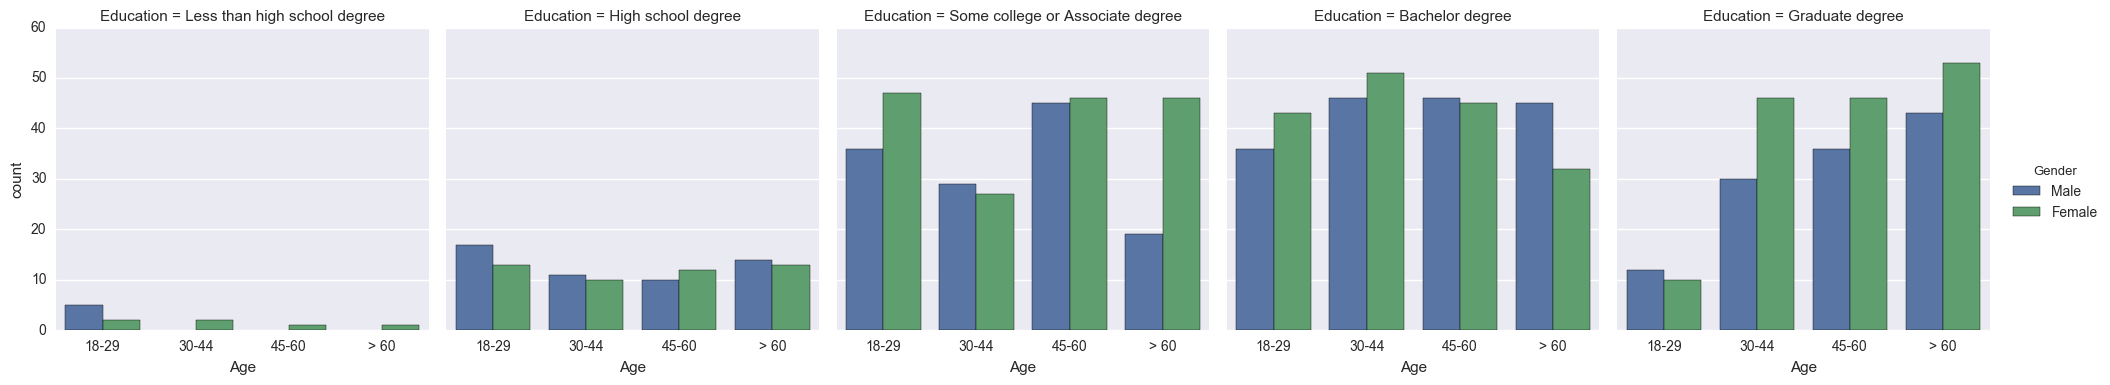

In [10]:
sns.factorplot(x="Age", col="Education", hue = 'Gender', data=comma,
               kind="count", size=4, aspect=1, ci=None, col_wrap = 5, legend_out =True,
               #col_order = ['$0 - $24,999', '$25,000 - $49,999', '$50,000 - $99,999', '$100,000 - $149,999', '$150,000+'],
               col_order = ['Less than high school degree', 'High school degree', 'Some college or Associate degree', 'Bachelor degree', 'Graduate degree'],
               order = ['18-29', '30-44', '45-60', '> 60'],
               #hue_order = ['Very unimportant', 'Somewhat unimportant', 'Neither important nor unimportant (neutral)', 'Somewhat important', 'Very important']
              )

Since only one type of graph will be used, a function was created to run graphs easily. 

In [11]:
def comparison_graph_comma(x, y, hue, wrap):
    Age_order = ['18-29', '30-44', '45-60', '> 60']
    Income_order = ['$0 - $24,999', '$25,000 - $49,999', '$50,000 - $99,999', '$100,000 - $149,999', '$150,000+']
    Education_order = ['Less than high school degree', 'High school degree', 'Some college or Associate degree', 'Bachelor degree', 'Graduate degree']
    Importance_order = ['Very unimportant', 'Somewhat unimportant', 'Neither important nor unimportant (neutral)', 'Somewhat important', 'Very important']
    Gender_order = ['Male', 'Female']
    Sentence_order = ['Used', 'Not Used']
    Location_order = ['East North Central', 'East South Central', 'Middle Atlantic', 'Mountain', 'New England', 'Pacific', 'South Atlantic', 'West North Central', 'West South Central']
    Heard_order = ['Yes', 'No']
    Care_order = ['Not at all', 'Not much', 'Some', 'A lot']
    Plural_order = ['Singular Used', 'Plural Used']
    
    
    if x == 'Age':
        x_order = Age_order
    if x == 'Income':
        x_order = Income_order
    if x == 'Education':
        x_order = Education_order
    if x == 'GrammarImportance':
        x_order = Importance_order
    if x == 'Gender':
        x_order = Gender_order
    if x == 'Sentence':
        x_order = Sentence_order
    if x == 'Location':
        x_order = Location_order
    if x == 'OxfordCommaHeard' or x == 'DataPlural':
        x_order = Heard_order
    if x =='OxfordCommaCare' or x == 'DataPluralCare':
        x_order = Care_order
    if x =='DataPluralUsage':
        x_order = Plural_order
        
    if y == 'Age':
        y_order = Age_order
    if y == 'Income':
        y_order = Income_order
    if y == 'Education':
        y_order = Education_order
    if y == 'GrammarImportance':
        y_order = Importance_order
    if y == 'Gender':
        y_order = Gender_order
    if y == 'Sentence':
        y_order = Sentence_order
    if y == 'Location':
        y_order = Location_order
    if y == 'OxfordCommaHeard' or y == 'DataPlural':
        y_order = Heard_order
    if y =='OxfordCommaCare' or y == 'DataPluralCare':
        y_order = Care_order
    if y =='DataPluralUsage':
        y_order = Plural_order
        
    if hue == 'Age':
        hue_ordered = Age_order
    if hue == 'Income':
        hue_ordered = Income_order
    if hue == 'Education':
        hue_ordered = Education_order
    if hue == 'GrammarImportance':
        hue_ordered = Importance_order
    if hue == 'Gender':
        hue_ordered = Gender_order
    if hue == 'Sentence':
        hue_ordered = Sentence_order
    if hue == 'Location':
        hue_ordered = Location_order
    if hue == 'OxfordCommaHeard' or hue == 'DataPlural':
        hue_ordered = Heard_order
    if hue =='OxfordCommaCare' or hue == 'DataPluralCare':
        hue_ordered = Care_order
    if hue =='DataPluralUsage':
        hue_ordered = Plural_order
    if hue == None:
        hue_ordered = None
    
    sns.factorplot(x=x, col=y, hue = hue, data=comma,
               kind="count", size=4, aspect=1, ci=None, col_wrap = wrap, legend_out =True,
               col_order = y_order, order = x_order, hue_order = hue_ordered)



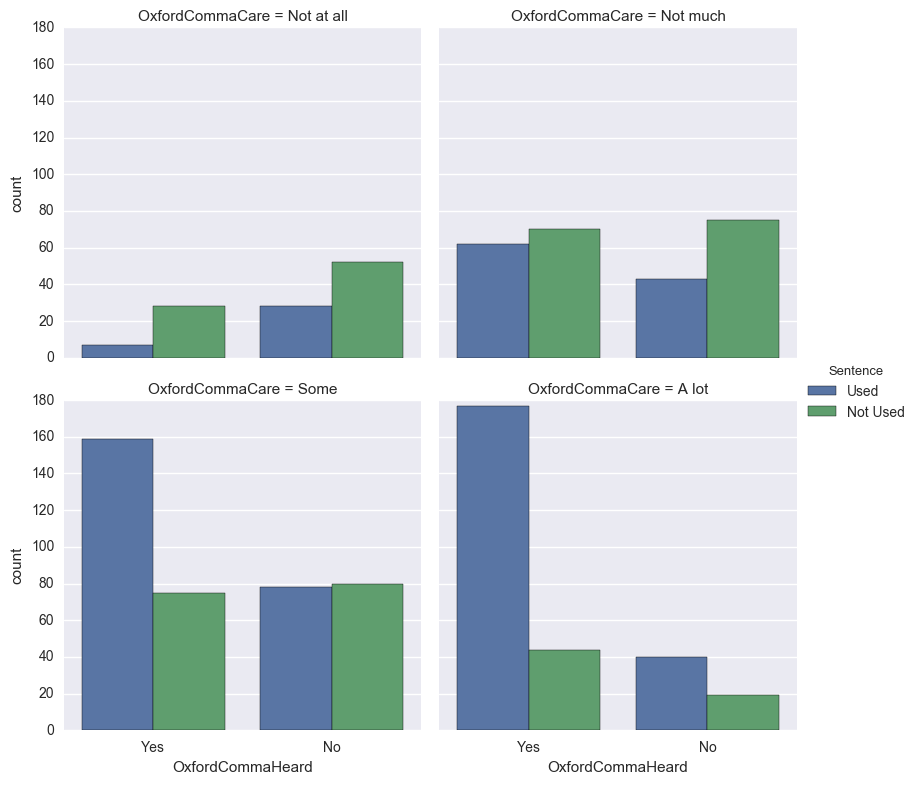

In [12]:
#do the people who used an Oxford Comma care about it and/or have the heard about it?
comparison_graph_comma('OxfordCommaHeard', 'OxfordCommaCare', 'Sentence', 2)

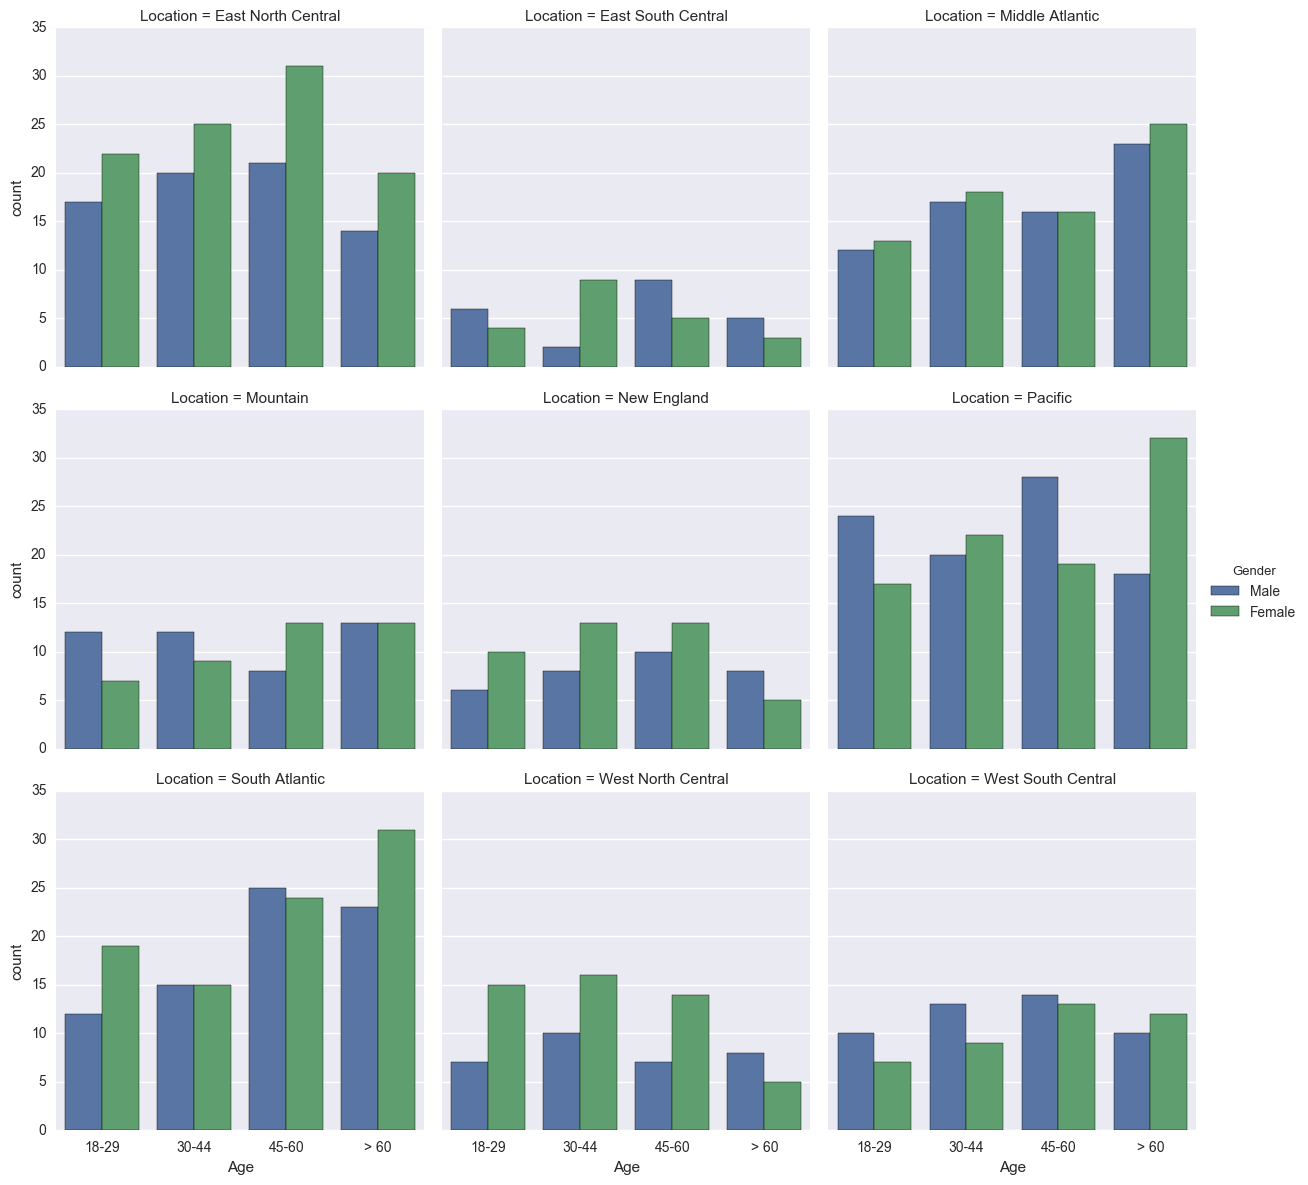

In [13]:
#who responded to the survey - age, location, gender
comparison_graph_comma('Age', 'Location', 'Gender', 3)

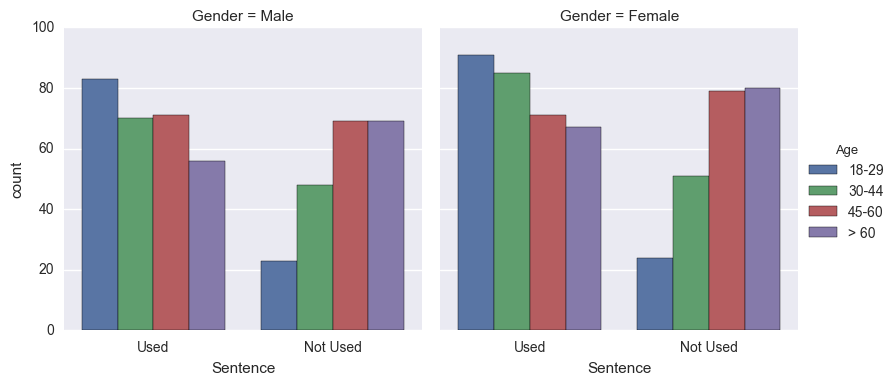

In [14]:
#who used the Oxford Comma more across age groups, male or female?
comparison_graph_comma('Sentence', 'Gender', 'Age', 2)

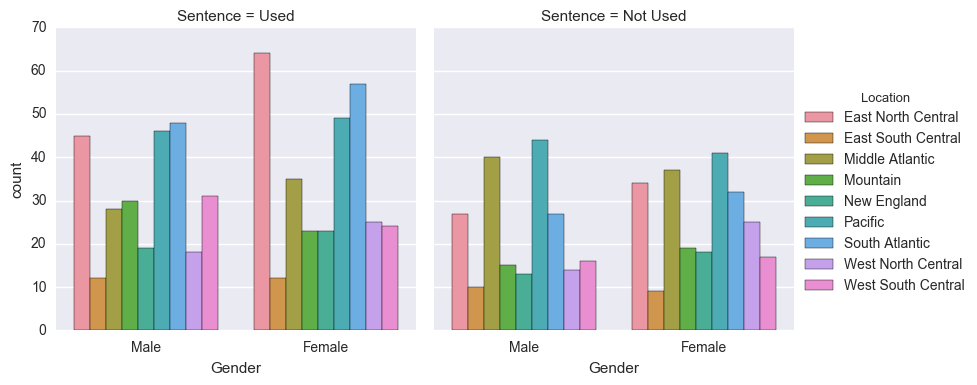

In [15]:
#who uses the Oxford Comma more across Locations?
comparison_graph_comma('Gender', 'Sentence', 'Location', 2)

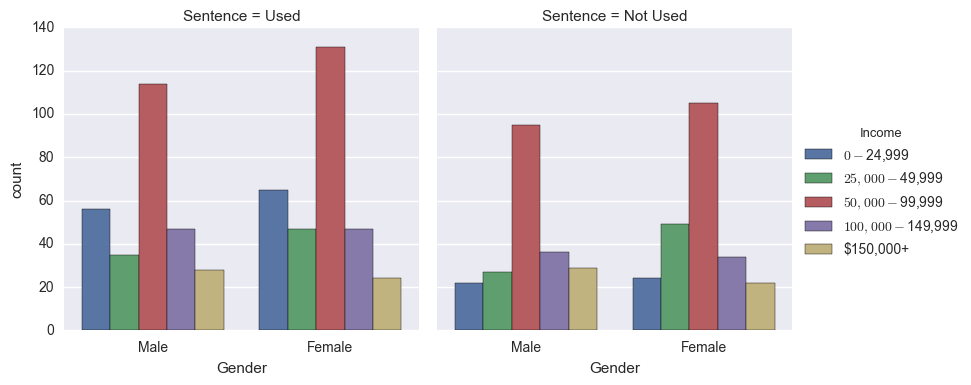

In [16]:
#Does income matter?
comparison_graph_comma('Gender', 'Sentence', 'Income', 2)

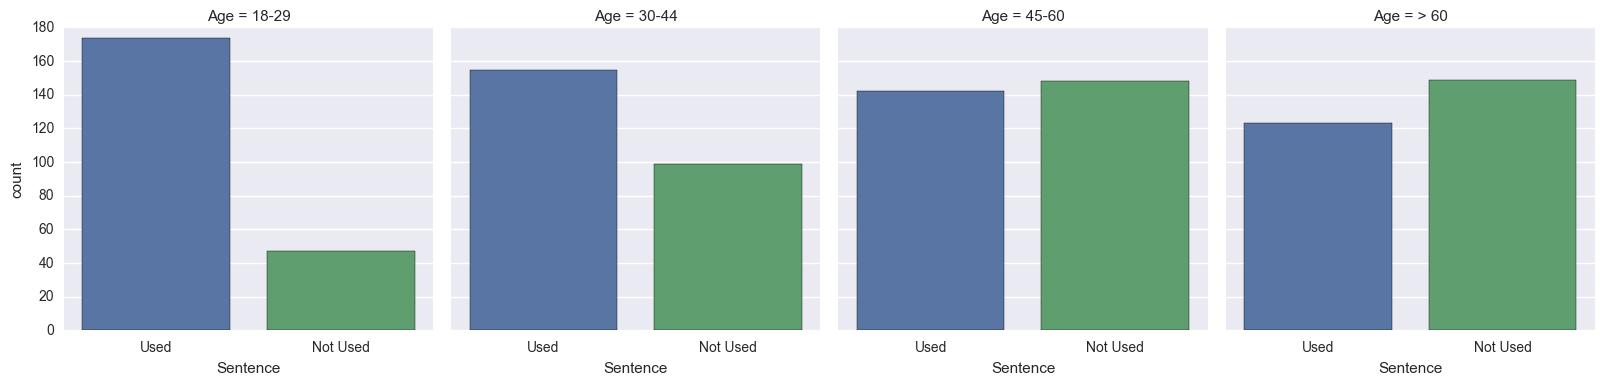

In [17]:
comparison_graph_comma('Sentence', 'Age', None, 4)

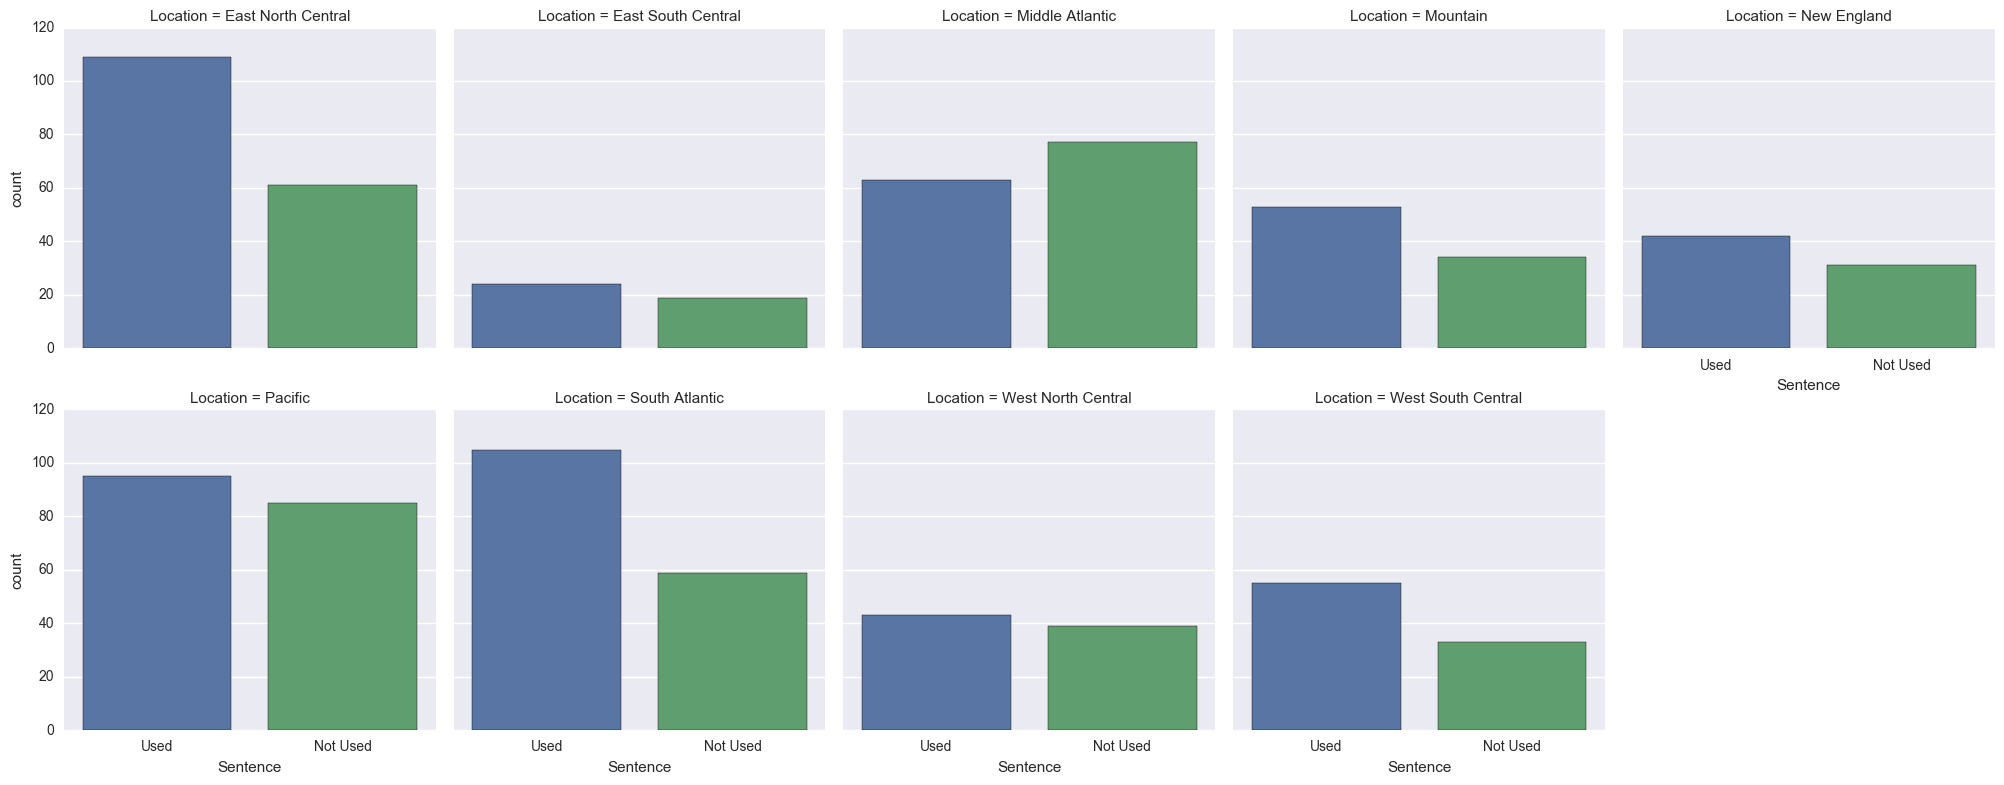

In [18]:
comparison_graph_comma('Sentence', 'Location', None, 5)

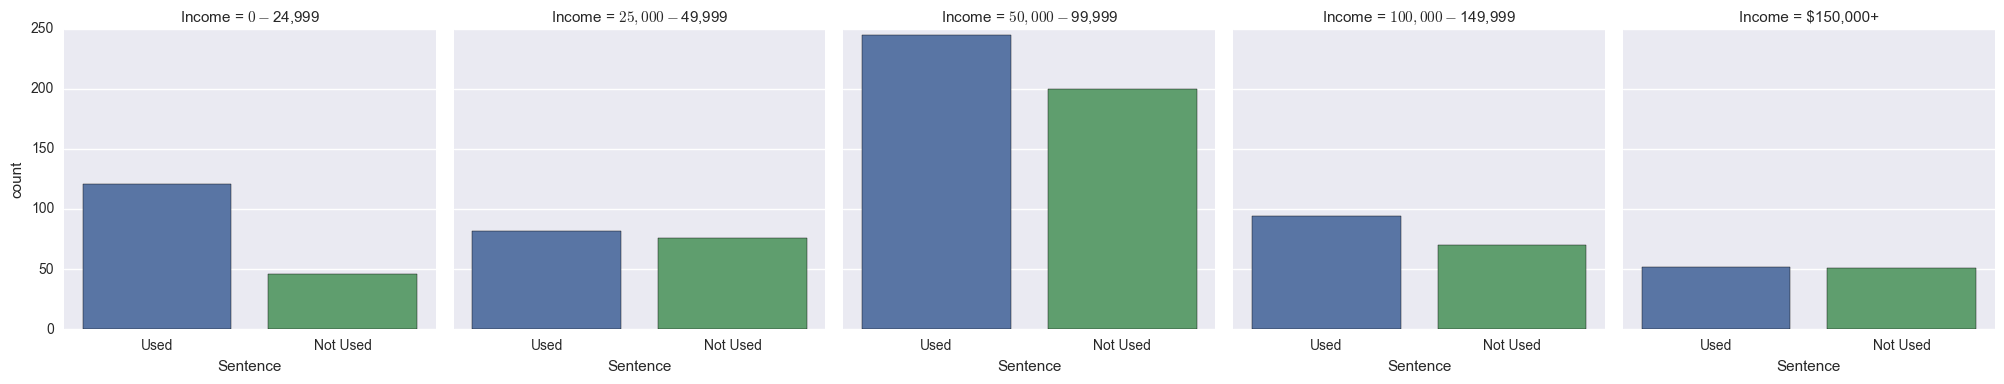

In [19]:
comparison_graph_comma('Sentence', 'Income', None, 5)

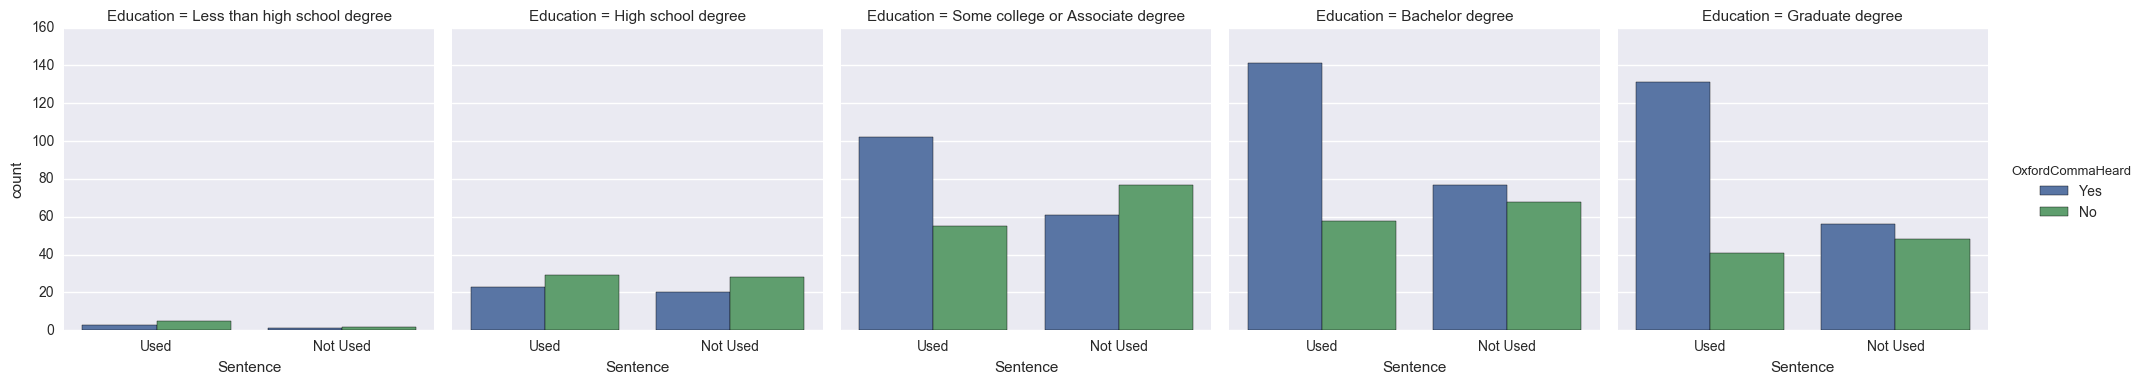

In [20]:
comparison_graph_comma('Sentence', 'Education', 'OxfordCommaHeard', 5)

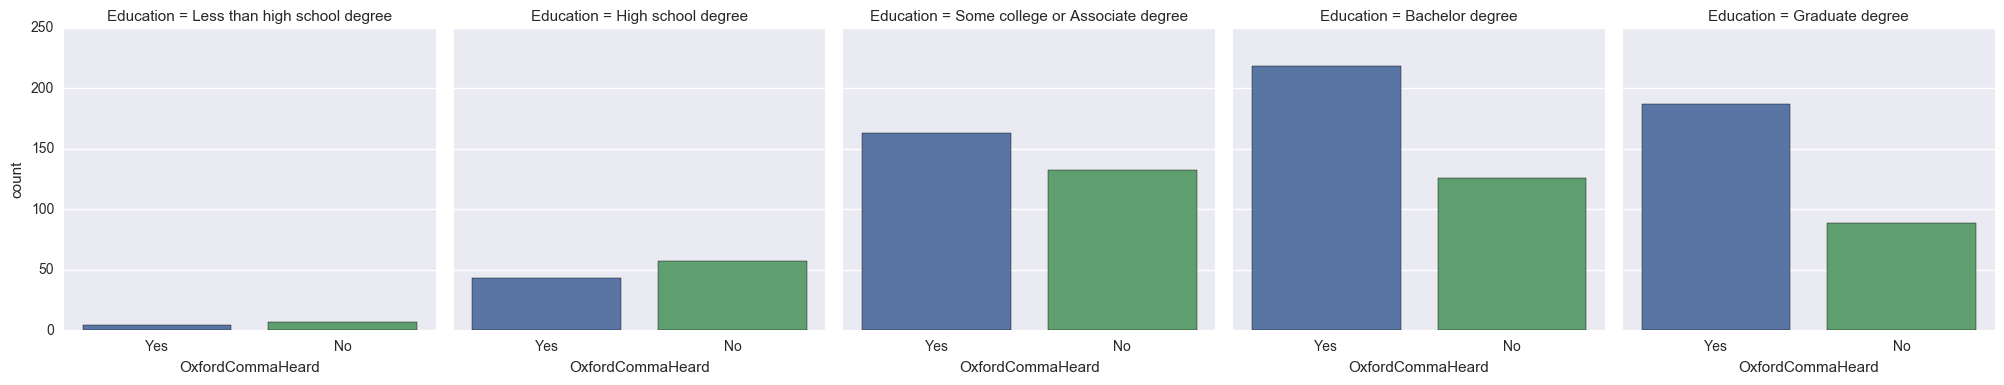

In [21]:
comparison_graph_comma( 'OxfordCommaHeard', 'Education', None, 5)

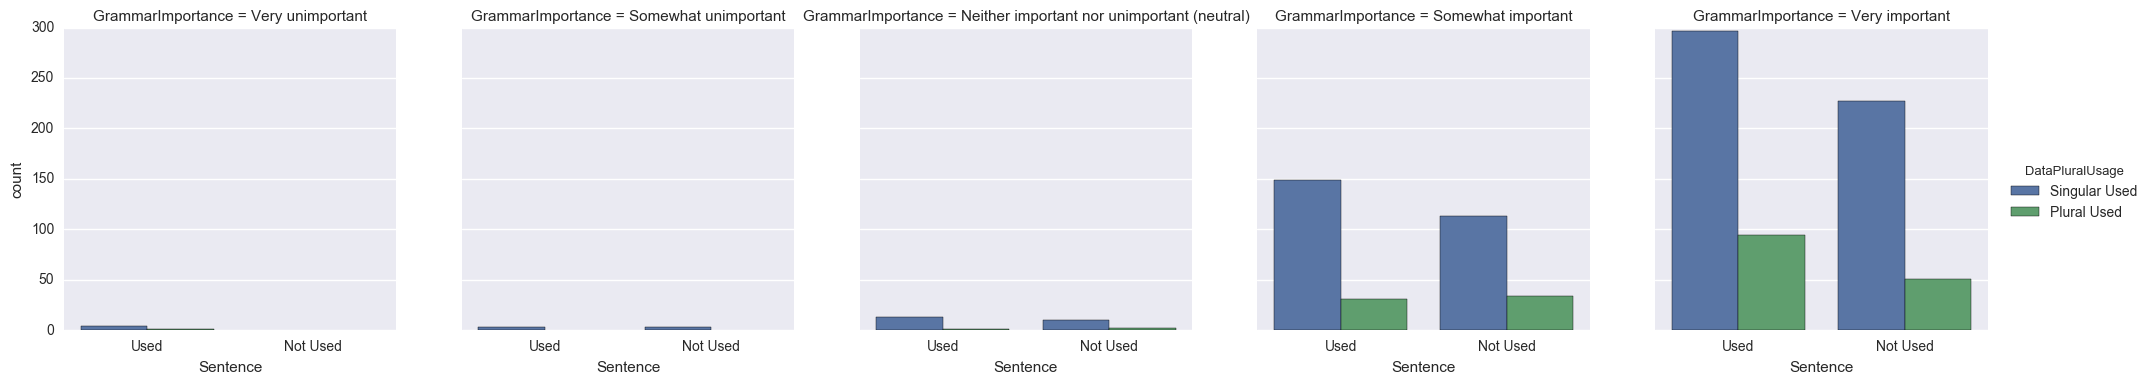

In [22]:
comparison_graph_comma('Sentence','GrammarImportance', 'DataPluralUsage', 5)

Break down the dataset into training and test sets

In [23]:
y = df3["Oxford Comma Use"]
x = df3.drop(["Oxford Comma Use", "RespondentID"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=42, stratify=y)

## Logistic Regression Section 

Set up a logistic regression object

In [24]:
glm = LogisticRegression()

In [25]:
commaglm = glm.fit(x_train, y_train)
commaglm_prob = commaglm.predict_proba(x_test)

Score the model, using training & testing data

In [26]:
commaglm.score(x_train, y_train)

0.68757539203860074

In [27]:
commaglm.score(x_test, y_test)

0.70192307692307687

In [28]:
#Actual rate of people who don't think the comma is important
y_train.mean()

0.5729794933655006

In [29]:
coef=[]
for i in commaglm.coef_:
    coef.append(i)

In [30]:
#DataFrame of the Coefficients 
dfCoef = pd.DataFrame(list(x.columns),
                  coef)
dfCoef

,0
0.236184,Heard of Oxford Comma
-1.805214,Oxford Care - Not at all
-1.466730,Oxford Care - Not much
-0.734860,Oxford Care - Some
0.030058,Data Use
-0.090834,Data is Plural
0.449477,Data Plural Care - Not at all
0.402470,Data Plural Care - Not much
0.231097,Data Plural Care - Some
0.169424,Grammar - Somewhat Important


## OLS Via Stat Model

In [31]:
# Fit regression model
results = sm.OLS(y_train, x_train).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Oxford Comma Use   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     41.14
Date:                Sat, 15 Apr 2017   Prob (F-statistic):          3.81e-148
Time:                        16:37:07   Log-Likelihood:                -532.89
No. Observations:                 829   AIC:                             1132.
Df Residuals:                     796   BIC:                             1288.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Heard of Oxf

## Support Vector Machine Model

In [32]:
param_grid_svc = {'polynomialfeatures__degree': np.arange(3),   
              'svc__C': [0.5,0.75,1,2,3]}
svcModel = make_pipeline(StandardScaler(),
                           PolynomialFeatures(),
                           SVC())

svcSearchSVC = GridSearchCV(svcModel, param_grid_svc)
svcSearchSVC.fit(x_train,y_train);
print(svcSearchSVC.best_params_)
#scores test set
scoressvc = cross_val_score(svcSearchSVC, x_test, y_test)
scoressvc.mean()

{'svc__C': 0.5, 'polynomialfeatures__degree': 1}


0.62969187675070026

## Naive Bayes

In [33]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d"% (x_test.shape[0],(y_test != y_pred).sum()))

Number of mislabeled points out of a total 208 points : 116


## Ridge Regression

In [34]:

#Creates params for SearchCV
param_grid_Ridge = {'polynomialfeatures__degree': np.arange(3),
                    'ridge__alpha': [.1, .2, .3, .4, .5, .6, .7, .8]}
#Creates Pipeline 
ridgeModel = make_pipeline(StandardScaler(),
                           PolynomialFeatures(),
                           Ridge(max_iter=10000))
#Creates Ridge object with the SearchCV
ridgeSearch = RandomizedSearchCV(ridgeModel, param_grid_Ridge)
#finds best params
ridgeSearch.fit(x_train,y_train);
#prints best params 
print(ridgeSearch.best_params_)
#scores training and test sets
scoresRidgeTest = cross_val_score(ridgeSearch, x_test, x_test)
#prints the score of the training set
scoresRidgeTest.mean()

{'polynomialfeatures__degree': 1, 'ridge__alpha': 0.7}


0.99597707308955152